## Preparation

Import all necessary packages

In [1]:
import os
from xml.etree import ElementTree as Et

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

This auxuliary function returns a dataframe containing publication year, month and filepath of all documents

In [2]:
def get_file_paths(CLEAN_DATA_DIR: str) -> pd.DataFrame:
    """
    Given a the clean_data directory, it returns dataframe containing year, month and filepath.
    param CLEAN_DATA_DIR: path to clean_data folder
    return: dataframe with columns year, month, path
    """
    documents = pd.DataFrame(
        [
            {
                "year": int(year),
                "month": int(month),
                "path": os.path.join(CLEAN_DATA_DIR, year, month, file),
            }
            for year in os.listdir(CLEAN_DATA_DIR)
            for month in os.listdir(os.path.join(CLEAN_DATA_DIR, year))
            for file in os.listdir(os.path.join(CLEAN_DATA_DIR, year, month))
            if os.path.isfile(os.path.join(CLEAN_DATA_DIR, year, month, file))
        ]
    )
    return documents

Reading xml file to DataFrame

In [3]:
def parse_xml_to_df(path: str) -> pd.DataFrame:
    """
    Parses xml file to a dataframe.
    param path: path to xml file
    return: dataframe
    """
    root = Et.parse(path).getroot()
    df = pd.DataFrame([node.attrib for node in root])
    return df

Reading tags connected to mathematics from the.

In [4]:
def get_relevant_tags(filepath: str, N=None) -> set:
    """Given a path to tags xml file, return N tags with the highest 'Count'
    param filepath: path to xml_file
    param N: number of tags
    return:
    """
    df = parse_xml_to_df(filepath)
    df.sort_values("Count", inplace=True, ascending=False)
    tags = df["TagName"].to_list()
    tags = [tag.split("-") for tag in tags]
    flat = [item for sublist in tags for item in sublist]
    if N:
        flat = flat[:N]

    return set(flat)

Plotting the results

In [5]:
def plot_time_series(x: pd.Series, y: pd.Series) -> None:
    """
    Plots time series data.
    param x: Timestamps (one per each month)
    param y: values
    return: None
    """
    fig, ax = plt.subplots()
    ax.plot(x, y)
    # format the ticks
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    plt.ylim(0, y.max() * 1.2)

Computing score how relevant math related tags are per each month. This function computes euclidean norm of tf-idf vector of scores of words listed in tags, then it computes mean score per each month.

In [6]:
def get_tf_idf_per_month(documents: pd.DataFrame, tags: set) -> pd.DataFrame:
    """
    Calculate how relevant math related tags are, per each month and year.
    :param documents: df containing columns: year, month, filepath to text files.
    :param tags: set of strings (tags)
    :return:
    """
    Tfidf = TfidfVectorizer(input="filename")
    tfidf_sparse_matrix = Tfidf.fit_transform(documents.path)
    # get matrix indices for tags connected to math
    tags_indices = [Tfidf.vocabulary_[tag] for tag in tags.intersection(Tfidf.get_feature_names())]
    # take subset of tfidf matrix corresponding to tags connected to math
    tfidf_math_tags = tfidf_sparse_matrix[:, tags_indices]
    # calculate euclidean norm of tfidf scores of tags connected to math
    norm = np.square(tfidf_math_tags.multiply(tfidf_math_tags).sum(axis=1))
    # assign information about year and month to tfidf matrix
    tf_idf_per_file = pd.DataFrame(
        {'norm': np.asarray(norm).reshape(-1),
         "year": documents.year.astype("int64"),
         "month": documents.month.astype("int64")}
    )
    # calculate mean per each month
    tf_idf_per_month = (
        tf_idf_per_file[["norm", "year", "month"]]
            .groupby(["year", "month"])
            .mean()
            .reset_index()
    )
    # timestamp for year and month (for plotting reasons)
    tf_idf_per_month["timestamp"] = pd.to_datetime(
        {"year": tf_idf_per_month.year, "month": tf_idf_per_month.month, "day": 1}
    )
    tf_idf_per_month.sort_values("timestamp", inplace=True)
    return tf_idf_per_month

## Measuring amount of mathematics in computer science

Importing documents and tags related to mathematics.

In [7]:
CLEAN_DATA_DIR = os.path.join(os.path.join("..", "clean_data"))
MATH_TAGS_FILEPATH = os.path.join("..", "tags", "math_tags.xml")
MATHOVERFLOW_TAGS_FILEPATH = os.path.join("..", "tags", "mathoverflow_tags.xml")
tags = get_relevant_tags(MATHOVERFLOW_TAGS_FILEPATH, 1000).union(
    get_relevant_tags(MATH_TAGS_FILEPATH, 2000)
)
documents = get_file_paths(CLEAN_DATA_DIR)

Computing the score

In [8]:
tf_idf_per_month = get_tf_idf_per_month(documents, tags)

Rejecting results from 2020 and ploting the results

Text(0, 0.5, 'Mean norm of tf-idf vector of tags related to mathematics')

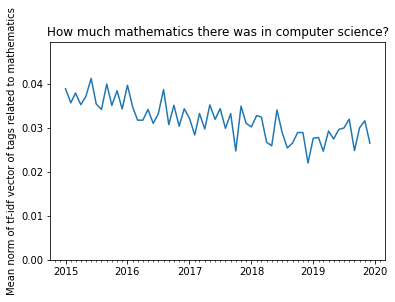

In [9]:
tf_idf_per_month = tf_idf_per_month[tf_idf_per_month["timestamp"].dt.year < 2020]
plot_time_series(
    x=tf_idf_per_month["timestamp"],
    y=tf_idf_per_month["norm"],
)
plt.title("How much mathematics there was in computer science?")
plt.ylabel("Mean norm of tf-idf vector of tags related to mathematics")